<a href="https://colab.research.google.com/github/1rd0/BekEnd_lab/blob/master/CNN_pytorch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №6

**Сверточные нейронные сети**

---

**Впишите в эту ячейку ваши ФИО, группу**.

ФИО:Рабдел Дмитрий Александрович

Группа:221-371

---


## Загрузка данных

В данной работе будет использоваться учебный датасет с изображениями персонажей из Симпсонов. Код для скачивания и распаковки приведен ниже, его требуется только выполнить и вo вкладке Files должна появиться папка `data`, а в ней папки `train` и `test`.

In [32]:
%%time

! wget -nc http://labcolor.space/rgb-test.zip
! unzip -o -q rgb-test.zip -d data
! wget -nc http://labcolor.space/rgb-train.zip
! unzip -o -q rgb-train.zip -d data

File ‘rgb-test.zip’ already there; not retrieving.

File ‘rgb-train.zip’ already there; not retrieving.

CPU times: user 32.3 ms, sys: 3.11 ms, total: 35.4 ms
Wall time: 1.53 s


## Создание объекта Dataset

Так как изображения в датасете организованы по папкам, где имя папки является ярлыком для данных, то мы можем воспользоваться базовым классом `ImageFolder`.

Одним из параметров является `transform`, для которого необходимо скомпоновать преобразования для наших изображений. В pytorch для преобразований сейчас есть два набора функций V1 и V2 и рекомендуется использовать V2, хоть напротив многих функций указано состояние beta.

Для компоновки функции из модуля v2 используйте `Compose`. Вам понадобится обязательно:
* ToImage() - преобразование в `Image` (подкласс torch.Tensor)
* RandomVerticalFlip() - случайное отзеркаливание
* ToDtype(torch.float32, scale=True) - преобразование из int во float
* Normalize() - нормализация изображений по полученным средним и стандартным отклонениям.

По желанию:
* RandomRotation() - поворот на случайный угол в указанном диапазоне
* Можете попробовать и другие варианты преобразований. [Документация API V2](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

В качестве примера будет показана работа с созданием Dataset для получения статистик изображения. Вам же необходимо будет создать `transforms` для обучения и проверки. При обучении вы используете весь набор обязательных преобразований, при обучении вам требуется только преобразовать изображение к тензору с плавающей точкой и провести нормализацию.

### Получение статистик для нормализации

In [33]:

import torch
import torchvision
from torchvision.transforms import v2

transforms_stats = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),v2.RandomVerticalFlip()
])

In [34]:
from torchvision.datasets import ImageFolder

stats_dataset = ImageFolder(root="./data/train", transform=transforms_stats)

In [35]:
imgs = [item[0] for item in stats_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")

Means R, G, B: (0.46520424, 0.40914688, 0.35447767)
Std R, G, B: (0.24928054, 0.22941431, 0.2450912)


**Почему значения средних и стандартных отклонений мы получаем только для обучающей выборки?**

Ваш ответ:избежать утечки информации из тестового набора данных в процесс обучения модели.




---


Используйте выведенные выше значения средних и стандартных отклонений в качестве аргументов функции `Normalize`.

значений пикселей изображения к определенным стандартным значениям, что помогает улучшить обучение модели и повысить ее производительность.



In [36]:
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import Normalize

transforms_train = v2.Compose([
#
# Ваш код
#v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    RandomVerticalFlip(),
    Normalize((mean_r, mean_g, mean_b), (std_r, std_g, std_b)),
])

transforms_test = v2.Compose([
#
# Ваш код
#v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
    , RandomVerticalFlip()

])

Теперь, когда есть необходимые `transforms` можно создать ImageFolder, указав в `root` путь до выборки и `transforms` в `transform`.

In [37]:
train_dataset =  ImageFolder(root="/content/data/train", transform=transforms_test) #  Ваш код

# по аналогии создайте датасет для проверочной части

#
test_dataset = ImageFolder(root="/content/data/test", transform=transforms_test)
#

In [38]:
# Количество изображений в обучающей и проверочной выборках
num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

# Количество классов в данных
num_classes = len(train_dataset.classes)

print("Количество изображений в обучающей выборке:", num_train_images)
print("Количество изображений в проверочной выборке:", num_test_images)
print("Количество классов в данных:", num_classes)

# Размеры и каналы изображений (первого изображения в обучающей выборке)
sample_image, _ = train_dataset[0]
image_shape = sample_image.shape

print("Размеры и каналы изображений:", image_shape)


Количество изображений в обучающей выборке: 8000
Количество изображений в проверочной выборке: 2000
Количество классов в данных: 10
Размеры и каналы изображений: torch.Size([3, 28, 28])


## Создание DataLoader

Далее необходимо подготовить три загрузчика данных:

1. Обучающий
2. Проверочный
3. Тестовый

Тестовый загрузчик делается из тестового Dataset, а обучающий и проверочный необходимо создать, используя [SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler), для его работы требуется массив индексов, по которым в дальнейшем загрузчик будет в случайном порядке брать изображения и лейблы.

In [39]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

val_size = 0.2

train_samples = len(train_dataset)
train_indices = list(range(train_samples))

split_value = int(np.floor(val_size * train_samples))
np.random.shuffle(train_indices)

train_idx, val_idx = train_indices[split_value:], train_indices[:split_value]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

[link text](https://)**Опишите своими словами, что делает каждая строчка кода в предыдущей ячейке.**

Ваш ответ:

 Импортирует класс который позволяет создавать сэмплеры для выборки случайных подмножеств из набора данных.
  указываем размер валидациооной выборки

 узнаем количесвто в трейн датасет

создаем лист  с индексами
перемешиваем индексы

создаем сэмплеры с помощью перемешенных индексов   


In [40]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler  = train_sampler) # не забудьте использовать нужный sampler

val_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler  = val_sampler) # не забудьте использовать нужный sampler

test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE)

**Какую задачу решает Dataloader?**

Ваш ответ:Dataloader помогает загружать данные для обучения модели.

**Почему использование трех выборок (обучающей, валидационной, тестовой) считается хорошей практикой?**

Ваш ответ:1. Обучающая выборка: используется для обучения модели.  

2. Валидационная выборка: используется для оценки качества модели в процессе обучения.

3. Тестовая выборка: используется для окончательной оценки  

Использование трех выборок помогает избежать переобучения   и недообучения  модели


## Создание модели

За основу можно взять модель LeNet-5, но скорее всего вам придется ее адаптировать под свою задачу, так как в большинстве случаев она написана под черно-белые изображения размером 32 на 32 пикселя.

Сверточные нейронные сети состоят из двух частей:
1. Слои свертки(функции свертки, активации, субдискретизации)
2. Полносвязные слои (MLP)

Слои можно объединить с помощью `nn.Sequential()`. А класс вашей модели должен наследоваться от `nn.Module`.

`def forward()` определяет прямой ход и должна возвращать итоговый результат работы модели - в данном случае логиты.

In [41]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 7 * 7, 100)  # Уплощаем данные после сверточных слоев
        self.fc2 = nn.Linear(100, num_classes)  # Выходной слой с количеством классов

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Уплощаем данные перед полносвязными слоями
        out = out.view(out.size(0), -1)
        # Прямой проход через полносвязные слои
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = self.fc2(out)
        return out


[link text](https://)**Опишите суть операции свертки.**

Ваш ответ:Операция свертки: Это как использование фильтра на изображении, чтобы найти особенности, такие как грани или текстуры. Мы "перетаскиваем" этот фильтр по изображению и записываем, что видим. Например, если фильтр обнаруживает горизонтальные черты, то на выходе мы получаем новое изображение, где эти черты выделены.

**Опишите суть операции субдискретизации.**

Ваш ответ:Это когда мы уменьшаем размер изображения, выбирая самые яркие или самые "важные" пиксели из небольших областей. Это помогает упростить изображение, оставляя только основные детали и уменьшая его размер.



## Создание объекта модели, функции потерь и оптимизатора

В качестве функции потерь будет использована перекрестная энтропия, в задании MLP вы фактически ее реализовали, но через набор отдельных функций.

В качестве оптимизатора можете взять стохастический градиентный спуск или Adam.

In [42]:
num_classes = 10
num_epochs = 10   # Пробуйте разные значения
learning_rate = 0.005  # Пробуйте разные значения
learning_rate = 1e-3
model = ConvNet(num_classes)

loss_fn = nn.CrossEntropyLoss()


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Цикл обучения

Попробуйте разные гиперпараметры для вашей модели. Попробуйте улучшить результат от первой попытки.

Вы можете по своему желанию добавить графики потерь и точности от эпохи.

Epoch [1/15], Loss: 1.0135, Accuracy: 65.97%
Epoch [2/15], Loss: 0.9508, Accuracy: 68.23%
Epoch [3/15], Loss: 0.9106, Accuracy: 69.41%
Epoch [4/15], Loss: 0.8876, Accuracy: 70.19%
Epoch [5/15], Loss: 0.8653, Accuracy: 70.30%
Epoch [6/15], Loss: 0.8296, Accuracy: 71.72%
Epoch [7/15], Loss: 0.7832, Accuracy: 73.78%
Epoch [8/15], Loss: 0.7735, Accuracy: 73.84%
Epoch [9/15], Loss: 0.7391, Accuracy: 75.22%
Epoch [10/15], Loss: 0.7353, Accuracy: 75.73%
Epoch [11/15], Loss: 0.7206, Accuracy: 75.55%
Epoch [12/15], Loss: 0.7136, Accuracy: 76.00%
Epoch [13/15], Loss: 0.6951, Accuracy: 76.56%
Epoch [14/15], Loss: 0.6472, Accuracy: 78.06%
Epoch [15/15], Loss: 0.6555, Accuracy: 77.95%


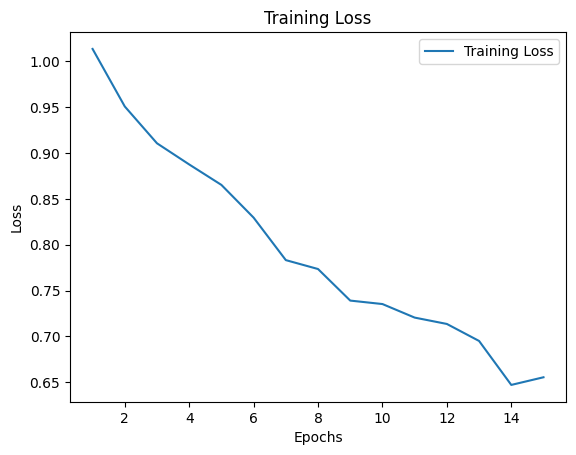

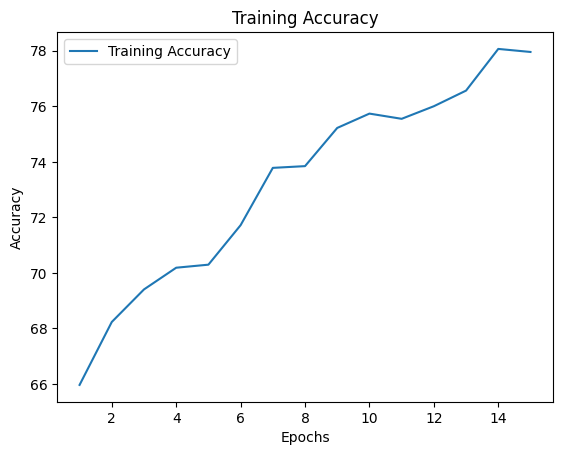

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Гиперпараметры
num_epochs = 15
learning_rate = 0.005

# Определение функции потерь - перекрестная энтропия
loss_fn = nn.CrossEntropyLoss()

# Определение оптимизатора - Adam

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Пустые списки для хранения потерь и точности
train_losses = []
train_accuracies = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels  in train_loader:
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Сохранение статистики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Сохранение потерь и точности на обучающем наборе
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Вывод статистики
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

# Визуализация графиков потерь и точности
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


## Итоговая оценка

Часть кода, которую вы реализовали для оценки модели на валидационной выборке, можно использовать для финальной проверки, указав нужный loader.

In [30]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Точность (accuracy) {100 * correct / total}')

Точность (accuracy) 29.0


**Точность работы модели на тестовой выборке**

Ваш ответ:29